# Time Series Analysis for Computer Science [CM0629] a.y. 2023-24 <br>Sebastiano Quintavalle 878500

## Dataset

The dataset is available at the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Red-Light-Camera-Violations/spqx-js37/data_preview) and consists of **daily traffic light violations**.

We read the file and inspect the first few lines.

In [1]:
import pandas as pd

FILE_PATH = "./data/red_light_camera_violations.csv"
violations = pd.read_csv(FILE_PATH, on_bad_lines="skip")

In [2]:
print(f"Length: {len(violations)}")
print(f"Columns: {list(violations.columns)}")

Length: 904942
Columns: ['INTERSECTION', 'CAMERA ID', 'ADDRESS', 'VIOLATION DATE', 'VIOLATIONS', 'X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE', 'LOCATION']


In [3]:
violations.head(10)

,INTERSECTION,CAMERA ID,ADDRESS,VIOLATION DATE,VIOLATIONS,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,IRVING PARK AND KILPATRICK,2763.0,4700 W IRVING PARK ROA,04/09/2015,4,NaN,NaN,NaN,NaN,NaN
1,VAN BUREN AND WESTERN,2054.0,2400 W VAN BUREN STREE,04/14/2015,5,NaN,NaN,NaN,NaN,NaN
2,115TH AND HALSTED,2552.0,11500 S HALSTED STREE,04/08/2015,5,NaN,NaN,NaN,NaN,NaN
3,IRVING PARK AND KILPATRICK,2764.0,4700 W IRVING PARK ROA,04/19/2015,4,NaN,NaN,NaN,NaN,NaN
4,ELSTON AND IRVING PARK,1503.0,3700 W IRVING PARK ROA,04/23/2015,3,NaN,NaN,NaN,NaN,NaN
5,31ST AND CALIFORNIA,2064.0,2800 W 31ST,09/14/2014,3,NaN,NaN,NaN,NaN,NaN
6,31ST AND CALIFORNIA,2064.0,2800 W 31ST,12/16/2014,1,NaN,NaN,NaN,NaN,NaN
7,4700 WESTERN,2141.0,4700 S WESTERN AVENUE,06/05/2019,3,1.161120e+06,1.873431e+06,41.808378,-87.684571,"(41.808378407946726, -87.68457071689552)"
8,31ST AND CALIFORNIA,2064.0,2800 W 31ST,01/30/2015,4,NaN,NaN,NaN,NaN,NaN
9,WESTERN AND DEVON,1211.0,6400 N WESTERN AVENUE,06/05/2019,2,1.159114e+06,1.942452e+06,41.997818,-87.690033,"(41.997817807026, -87.69003303469276)"


## Preprocessing

We only keep the columns we are mainly interested in, that are the ***CameraID*** and it's location in terms of ***latitude*** and ***longitude***, along with the ***violation date*** and the ***number of violations***.

In [4]:
violations = violations.loc[:, ['CAMERA ID', 'VIOLATION DATE', 'VIOLATIONS', 'LATITUDE', 'LONGITUDE']]

We rename the columns.

In [5]:
violations.rename(columns={
    'CAMERA ID': 'CameraID',
    'VIOLATION DATE': 'Date',
    'VIOLATIONS': 'Violations',
    'LATITUDE': 'Lat',
    'LONGITUDE': 'Lon'
}, inplace=True)

We delete all rows with unkown ID or unknown location.

In [6]:
violations.dropna(subset=['CameraID'], inplace=True)
violations.dropna(subset=['Lat', 'Lon'], inplace=True)

We cast the Camera-ID and the numer of violation to integer.

In [7]:
violations['CameraID'] = violations['CameraID'].astype(int)
violations['Violations'] = violations['Violations'].astype(int)

We add a new column referring to the violation date as a ***date-type*** so we can sort over it.

In [8]:
violations['DateT'] = pd.to_datetime(violations['Date'], format='%m/%d/%Y')
violations.sort_values(by='DateT', inplace=True)

Let's take a look to the modified dataset.

In [9]:
violations.head(10)

,CameraID,Date,Violations,Lat,Lon,DateT
762534,2163,07/01/2014,1,41.793623,-87.703618,2014-07-01
629375,1563,07/01/2014,9,41.946840,-87.688320,2014-07-01
668400,1454,07/01/2014,3,41.931249,-87.776029,2014-07-01
743537,2624,07/01/2014,10,41.758074,-87.624672,2014-07-01
561738,1143,07/01/2014,6,41.968987,-87.669516,2014-07-01
401265,1701,07/01/2014,2,41.925540,-87.648912,2014-07-01
265168,2741,07/01/2014,2,41.993841,-87.714242,2014-07-01
756892,2003,07/01/2014,2,41.917042,-87.746176,2014-07-01
673627,1513,07/01/2014,1,41.932205,-87.697679,2014-07-01
453288,2123,07/01/2014,4,41.838534,-87.617046,2014-07-01


## Deleting cameras not working in the entire period

We want to ensure that **all cameras operate in the same time range**. If not when summing up the number of violations in a certain area may lead to unpredictable drifts in the tend.

In [10]:
max_date_2014 = violations.loc[violations['DateT'].dt.year == 2014, 'DateT'].dropna().max()
min_date_2023 = violations.loc[violations['DateT'].dt.year == 2023, 'DateT'].dropna().min()

print(f"Boundary dates:")
print(f"- from {max_date_2014}")
print(f"- to   {min_date_2023}")

Boundary dates:
- from 2014-12-31 00:00:00
- to   2023-01-01 00:00:00


We consider the whole **period from 2015 to 2022**.

In [11]:
START = pd.to_datetime("01/01/2015")
END   = pd.to_datetime("12/31/2022")

We retrieve starting and ending date for each camera.

In [16]:
camera_start_end = violations.groupby(['CameraID']).agg({'DateT': ['min', 'max']}).reset_index()
camera_start_end.columns = ['CameraID', 'Start', 'End']

In [17]:
camera_start_end.head(10)

,CameraID,Start,End
0,1002,2014-07-01,2023-11-29
1,1003,2014-07-01,2023-11-29
2,1011,2014-07-01,2023-11-29
3,1014,2014-07-01,2023-11-29
4,1023,2014-07-01,2023-11-29
5,1024,2014-07-01,2023-11-29
6,1031,2014-07-01,2023-11-29
7,1034,2014-07-01,2023-11-29
8,1041,2014-07-01,2023-11-29
9,1042,2014-07-01,2023-11-29


In [18]:
camera_start_end = {
    camera: (start, end)
    for camera, start, end in list(camera_start_end.itertuples(index=False, name=None))
}

We retrieve and delete all cameras not fulfilling our requirements.

In [19]:
cameras_to_delete = [
     camera for camera, (s, e) in camera_start_end.items() if s > START or e < END
]
len(cameras_to_delete)

70

In [20]:
violations = violations[~violations.loc[: , 'CameraID'].isin(cameras_to_delete)]

For the remaining cameras, we delete each date not involved in considered one.

In [21]:
violations = violations[(violations['DateT'] >= START) & (violations['DateT'] <= END)]

The final Dataset result now in the **period 2015-2022** and involves all **cameras always active** in such period.

In [22]:
violations.head()

,CameraID,Date,Violations,Lat,Lon,DateT
564068,1024,01/01/2015,4,41.953025,-87.786683,2015-01-01
509040,1562,01/01/2015,2,41.946820,-87.688407,2015-01-01
603386,1941,01/01/2015,4,41.895787,-87.686991,2015-01-01
765389,1243,01/01/2015,1,42.011662,-87.812781,2015-01-01
441344,1284,01/01/2015,5,41.968226,-87.739599,2015-01-01


## Grouping cameras

We have too many cameras to be processed individually and we need to find a strategy to group them together.

In [23]:
len(violations.loc[:, "CameraID"].unique())

276

Chicago city is divided in 9 'Sides': we **group cameras basing on their beloging region**.

In [31]:
from IPython.display import Image
from urllib.request import Request, urlopen

IMAGE_URL = 'https://jhc.ryb.mybluehost.me/wp-content/uploads/2020/10/Chicago-Community-Areas-Map-min.png'
IMAGE_PATH = './out/chicago_sides.png'


request = Request(
    IMAGE_URL, 
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
)
with urlopen(request) as response:
    with open(IMAGE_PATH, 'wb') as out_file:
        out_file.write(response.read())

Image(url=IMAGE_PATH)

We leverage on **geodata** available at the Chicago Data Portal to get [regions polygons](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6).

In [33]:
import geopandas as gpd

GEO_PATH = './data/regions_poly.geojson'
gdf_areas = gpd.read_file(GEO_PATH)

gdf_areas.rename(columns={'area_num_1': 'Area'}, inplace=True)
gdf_areas.drop(columns=[
    'community', 'area', 'shape_area', 'perimeter',
    'area_numbe', 'comarea_id', 'comarea', 'shape_len'],
    inplace=True
)

The regions are described by an identifier and a polygon.

In [34]:
gdf_areas.head(10)

,Area,geometry
0,35,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,36,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,37,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,38,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,39,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."
5,4,"MULTIPOLYGON (((-87.67441 41.97610, -87.67440 ..."
6,40,"MULTIPOLYGON (((-87.60604 41.78587, -87.60627 ..."
7,41,"MULTIPOLYGON (((-87.58038 41.80253, -87.58040 ..."
8,42,"MULTIPOLYGON (((-87.57714 41.78615, -87.57714 ..."
9,1,"MULTIPOLYGON (((-87.65456 41.99817, -87.65574 ..."


We also transform our camera information into a geographic DataFrame.

In [35]:
from shapely.geometry import Point

camera_data = violations.loc[:, ["CameraID", "Lat", "Lon"]].drop_duplicates().to_records(index=False).tolist()

gdf_cameras = gpd.GeoDataFrame(
    camera_data, columns=['CameraID', 'Lat', 'Lon'],
    geometry=[Point(lon, lat) for _, lat, lon in camera_data]
)

gdf_cameras

,CameraID,Lat,Lon,geometry
0,1024,41.953025,-87.786683,POINT (-87.78668 41.95302)
1,1562,41.946820,-87.688407,POINT (-87.68841 41.94682)
2,1941,41.895787,-87.686991,POINT (-87.68699 41.89579)
3,1243,42.011662,-87.812781,POINT (-87.81278 42.01166)
4,1284,41.968226,-87.739599,POINT (-87.73960 41.96823)
...,...,...,...,...
272,1252,42.012371,-87.690394,POINT (-87.69039 42.01237)
273,1421,41.924152,-87.756295,POINT (-87.75629 41.92415)
274,2003,41.917042,-87.746176,POINT (-87.74618 41.91704)
275,1034,41.975763,-87.787934,POINT (-87.78793 41.97576)


We associate each **camera** to the **polygon** it's contained in.

In [36]:
gdf_camera_area = gpd.sjoin(gdf_cameras, gdf_areas, how="left", predicate="within")

C:\Users\user.LAPTOP-G27BJ7JO\AppData\Local\Temp\ipykernel_12120\2762238780.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_camera_area = gpd.sjoin(gdf_cameras, gdf_areas, how="left", predicate="within")


In [37]:
gdf_camera_area.head(10)

,CameraID,Lat,Lon,geometry,index_right,Area
0,1024,41.953025,-87.786683,POINT (-87.78668 41.95302),16,17
1,1562,41.946820,-87.688407,POINT (-87.68841 41.94682),47,5
2,1941,41.895787,-87.686991,POINT (-87.68699 41.89579),24,24
3,1243,42.011662,-87.812781,POINT (-87.81278 42.01166),76,9
4,1284,41.968226,-87.739599,POINT (-87.73960 41.96823),13,14
5,1343,41.985650,-87.655336,POINT (-87.65534 41.98565),75,77
6,1563,41.946840,-87.688320,POINT (-87.68832 41.94684),47,5
7,2712,41.780008,-87.625523,POINT (-87.62552 41.78001),66,69
8,2433,41.714323,-87.643067,POINT (-87.64307 41.71432),71,73
9,2523,41.722579,-87.575293,POINT (-87.57529 41.72258),49,51


We associate each ***CameraID*** to the corresponding ***Area***.

In [38]:
camera_area = {
    camera_id: int(area)
    for camera_id, area in gdf_camera_area.loc[:, ['CameraID', "Area"]].to_records(index=False).tolist()
}

We use a dictionary that maps each **region** to the **list of areas**.

In [39]:
regions = {
  "FarNorth":     [1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 76, 77],
  "NorthWest":    [15, 16, 17, 18, 19, 20],
  "North":        [5, 6, 7, 21, 22],
  "West":         [23, 24, 25, 26, 27, 28, 29, 30, 31],
  "Central":      [8, 32, 33],
  "South":        [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 60, 69],
  "SouthWest":     [56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68],
  "FarSouthWest": [70, 71, 72, 73, 74, 75],
  "FarSouthEast": [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55],
}

def get_sides_name(area_id):

  for region_name, area_list in regions.items():

    if area_id in area_list:
      return region_name

  raise(f"{area_id} not contained in any region!")

In [40]:
camera_region = {
    camera_id: get_sides_name(area_id=area_id)
    for camera_id, area_id in camera_area.items()
}

We use this mapping to create the new column which describe the region.

In [42]:
violations['Region'] = violations["CameraID"].map(camera_region)

We use *folium* technology to visualize camera in the map.

In [43]:
CAMERA_MAP = "./out/camera_map.html"

# Available  ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
#             'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
#             'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray',
#             'black', 'lightgray']

region_colors = {
  "FarNorth": 'red',
  "NorthWest": 'cadetblue',
  "North": 'lightgreen',
  "West": 'orange',
  "Central": 'purple',
  "South": 'lightgray',
  "SouthWest": 'lightblue',
  "FarSouthWest": 'beige',
  "FarSouthEast": 'pink',
}

In [44]:
import folium
from numpy import mean

camera_map = violations.loc[:, ['CameraID', "Lat", "Lon", "Region"]].drop_duplicates().to_records(index=False).tolist()

lats = [lat for _, lat,   _, _ in camera_map]
lons = [lon for _,   _, lon, _ in camera_map]

map = folium.Map(location=[mean(lats), mean(lons)])
map.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])

for camera_id, lat, lon, region in camera_map:

    folium.Marker(
        location=[lat, lon],
        popup=f'CameraID: {camera_id}',
        icon=folium.Icon(color=region_colors[region], icon='camera')
    ).add_to(map)


map.save(CAMERA_MAP)

In [45]:
import webbrowser
from os import path

webbrowser.open(url=path.abspath(CAMERA_MAP), new=2)

True

## Aggregating over cameras

We **aggregate** all cameras part of the **same region** by **summing up** the **number of violations**.

In [47]:
violations = violations.groupby(["Region", "Date", "DateT"]).agg({'Violations': 'sum'}).reset_index()

In [48]:
violations.head(10)

,Region,Date,DateT,Violations
0,Central,01/01/2015,2015-01-01,24
1,Central,01/01/2016,2016-01-01,54
2,Central,01/01/2017,2017-01-01,86
3,Central,01/01/2018,2018-01-01,33
4,Central,01/01/2019,2019-01-01,29
5,Central,01/01/2020,2020-01-01,22
6,Central,01/01/2021,2021-01-01,25
7,Central,01/01/2022,2022-01-01,24
8,Central,01/02/2015,2015-01-02,28
9,Central,01/02/2016,2016-01-02,61


We split the dataset by region.

In [49]:
regions = {
    region_name: region_df for region_name, region_df in violations.groupby('Region')
}

Since we need to have observation for each period we compute possible clusters of dates.

In [50]:
from datetime import datetime, timedelta

def find_date_clusters(date_list):

    date_format = "%m/%d/%Y"
    date_list = sorted(date_list, key=lambda x: datetime.strptime(x, date_format))

    clusters = []
    current_cluster = [date_list[0]]

    for i in range(1, len(date_list)):
        current_date = datetime.strptime(date_list[i], date_format)
        previous_date = datetime.strptime(current_cluster[-1], date_format)

        if current_date == previous_date + timedelta(days=1):
            current_cluster.append(date_list[i])
        else:
            clusters.append((current_cluster[0], current_cluster[-1], len(current_cluster)))
            current_cluster = [date_list[i]]

    # Add the last cluster
    if current_cluster:
        clusters.append((current_cluster[0], current_cluster[-1], len(current_cluster)))

    return clusters

In [51]:
not_single_cluster = []

for region_name, region_df in regions.items():

    print(f"{region_name}")

    date_list = list(region_df.loc[: , "Date"])

    date_clusters = find_date_clusters(date_list=date_list)

    if len(date_clusters) > 1:
      not_single_cluster.append(region_name)

    for start_date, end_date, length in date_clusters:
        print(f"Start Date: {start_date}, End Date: {end_date}, Length: {length}")
    
    print()


Central
Start Date: 01/01/2015, End Date: 12/06/2021, Length: 2532
Start Date: 12/08/2021, End Date: 12/31/2022, Length: 389

FarNorth
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

FarSouthEast
Start Date: 01/01/2015, End Date: 12/06/2021, Length: 2532
Start Date: 12/08/2021, End Date: 12/31/2022, Length: 389

FarSouthWest
Start Date: 01/01/2015, End Date: 12/06/2021, Length: 2532
Start Date: 12/08/2021, End Date: 12/31/2022, Length: 389

North
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

NorthWest
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

SoutWest
Start Date: 01/01/2015, End Date: 12/06/2021, Length: 2532
Start Date: 12/08/2021, End Date: 12/31/2022, Length: 389

South
Start Date: 01/01/2015, End Date: 12/06/2021, Length: 2532
Start Date: 12/08/2021, End Date: 12/31/2022, Length: 389

West
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922


For some regions the obserbation on *12/07/2021* is **missing**, we take the average between the previous and the next day.

In [53]:
not_single_cluster

['Central', 'FarSouthEast', 'FarSouthWest', 'SoutWest', 'South']

In [54]:
means = []

for region_names in not_single_cluster:

  mean_ = violations[
      (violations["Region"] == region_names) & ((violations["Date"] == "12/06/2021") | (violations["Date"] == "12/08/2021"))
  ].loc[:, "Violations"].mean()

  means.append(int(mean_))

means

[30, 108, 125, 133, 168]

In [55]:
artificial_rows = pd.DataFrame({
    "Region": not_single_cluster,
    "Date": ["12/07/2021"]*len(not_single_cluster),
    "Violations": means,
    "DateT": [pd.to_datetime("12/07/2021", format='%m/%d/%Y')]*len(not_single_cluster)
})

We add the generated rows to the original timeseries.

In [56]:
violations = pd.concat([violations, artificial_rows])
violations.sort_values(by='DateT', inplace=True)

Let's check if finally all areas cover the entire period.

In [57]:
areas = {
    area_name: area_df for area_name, area_df in violations.groupby('Region')
}

for station_name, station_df in areas.items():

    print(f"{station_name}")

    date_list = list(station_df.loc[: , "Date"])

    for start_date, end_date, length in find_date_clusters(date_list=date_list):
        print(f"Start Date: {start_date}, End Date: {end_date}, Length: {length}")
        print()

Central
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

FarNorth
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

FarSouthEast
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

FarSouthWest
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

North
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

NorthWest
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

SoutWest
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

South
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922

West
Start Date: 01/01/2015, End Date: 12/31/2022, Length: 2922


## Times series

We use these data to plot **time series**.

In [58]:
region_html_colors = {
  "FarNorth": '#f7a9a0',
  "NorthWest": '#bdbada',
  "North": '#b4d56b',
  "West": '#fbb462',
  "Central": '#bc80b8',
  "South": '#d9d9c0',
  "SoutWest": '#d7eff7',
  "FarSouthWest": '#d9bc73',
  "FarSouthEast": '#facee1',
}

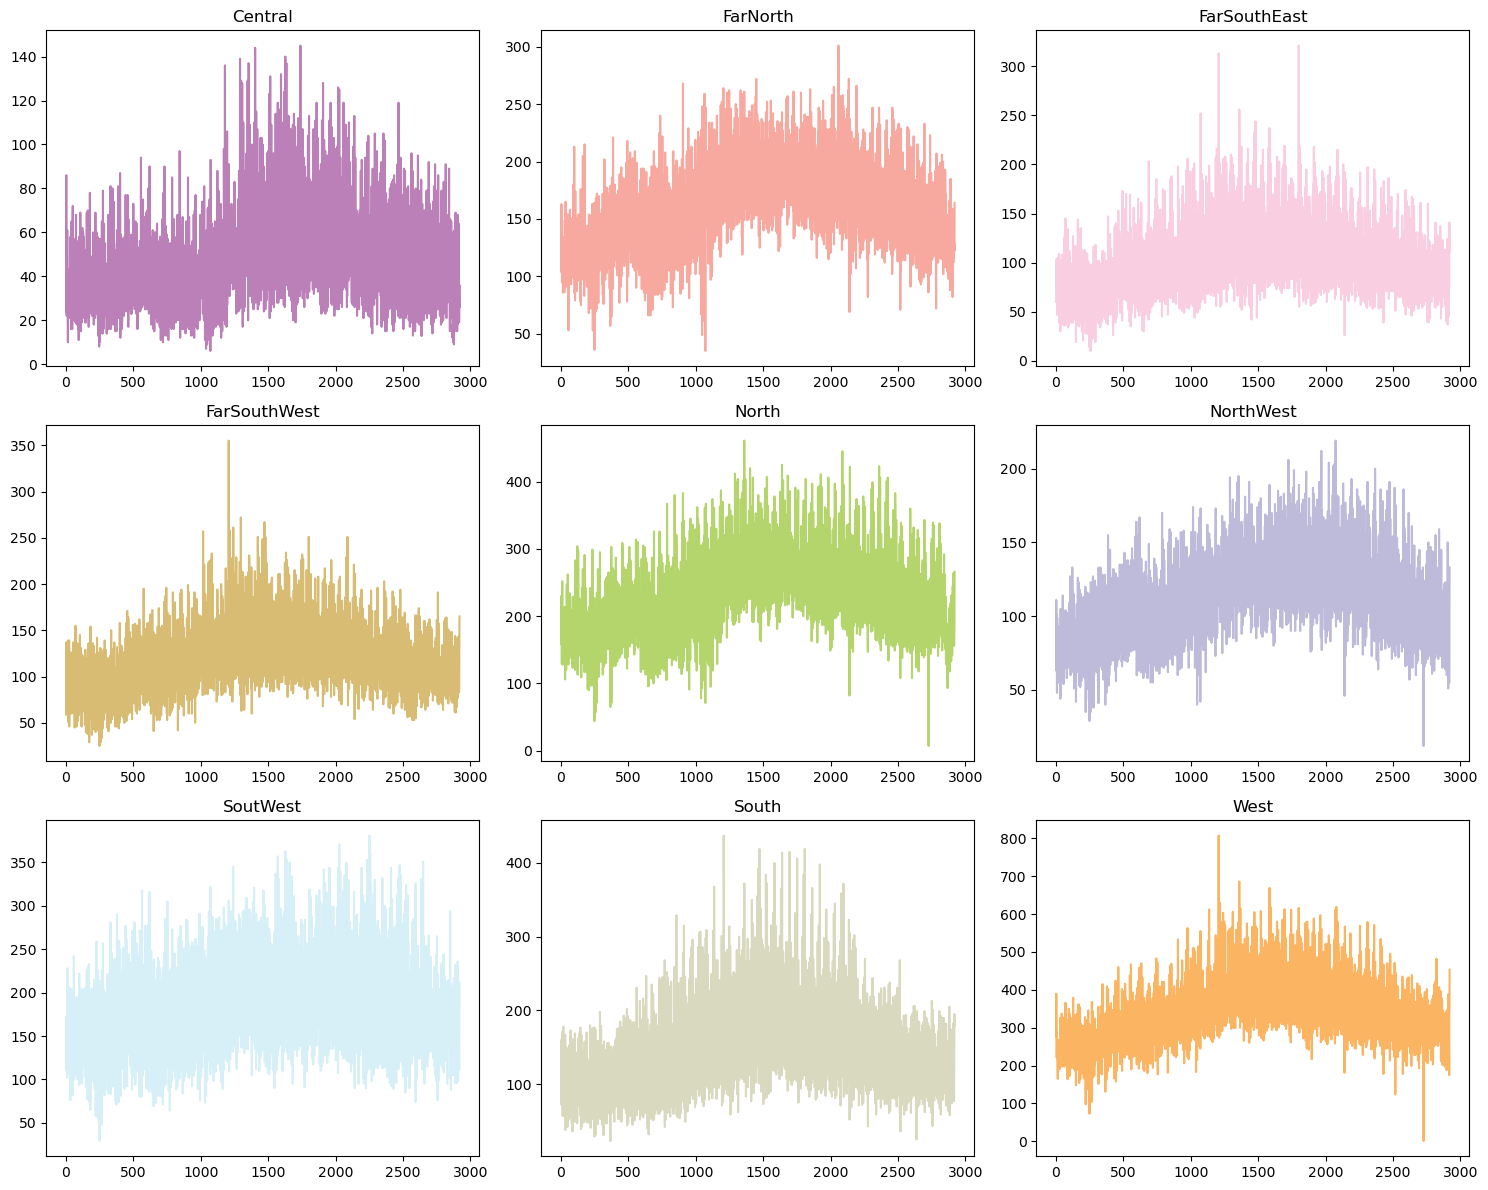

In [59]:
import matplotlib.pyplot as plt

# Set the figure size
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for (region_name, region_df), ax in zip(regions.items(), axes.flatten()):
    values = region_df.loc[:, "Violations"].to_numpy()

    ax.plot(values, color=region_html_colors[region_name])
    ax.set_title(region_name)

# Adjust layout
plt.tight_layout()
plt.show()

Finally we save the CSV for further analysis.

In [60]:
violations.drop(columns=["DateT"], inplace=True)
violations.to_csv("./out/violations.csv", header=True, index=False)